In [ ]:
# !pip install -q kaggle 

In [ ]:
# !mkdir ~/.kaggle

In [ ]:
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !kaggle competitions download -c gan-getting-started

In [16]:
# !unzip gan-getting-started.zip

Archive:  gan-getting-started.zip
replace monet_jpg/000c1e3bff.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace monet_jpg/011835cfbf.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace monet_jpg/0260d15306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace monet_jpg/049e293b93.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# learning by copying😜
> ~https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial~
> https://www.kaggle.com/code/peakwhisky/monet-dcgan




In [ ]:
# !pip3 install tensorflow_addons

In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import glob
import time

In [59]:
image_feature_description = {
    
    'image_name':tf.io.FixedLenFeature([], tf.string),
    'image':tf.io.FixedLenFeature([], tf.string),
    'target':tf.io.FixedLenFeature([], tf.string)
}


In [60]:
IMG_SIZE = [256,256]
def decode_image(image):
  image = tf.image.decode_jpeg(image,channels=3)
  image = (tf.cast(image,tf.float32)/127.5)-1 
  image = tf.reshape(image,[*IMG_SIZE,3])
  return image

def parse_image_function(example_proto):
  example= tf.io.parse_single_example(example_proto, image_feature_description)
  image = decode_image(example['image'])
  return image

In [70]:
AUTOTUNE = tf.data.AUTOTUNE 
def load_data(filename):
  raw_ds = tf.data.TFRecordDataset(filename)
  raw_ds = raw_ds.map(parse_image_function,num_parallel_calls=AUTOTUNE)
  return raw_ds 



In [63]:
import os 
MONET_FILENAMES = os.listdir('monet_tfrec')
print(len(MONET_FILENAMES))

5


In [64]:
MONET_FILENAMES

['monet08-60.tfrec',
 'monet00-60.tfrec',
 'monet12-60.tfrec',
 'monet16-60.tfrec',
 'monet04-60.tfrec']

In [65]:
monet_tfrec ='monet_tfrec'
MONET_PATHS= [os.path.join(monet_tfrec,filename) for filename in MONET_FILENAMES]

In [66]:
MONET_PATHS

['monet_tfrec/monet08-60.tfrec',
 'monet_tfrec/monet00-60.tfrec',
 'monet_tfrec/monet12-60.tfrec',
 'monet_tfrec/monet16-60.tfrec',
 'monet_tfrec/monet04-60.tfrec']

In [71]:
monet_ds = load_data(MONET_PATHS).batch(1)

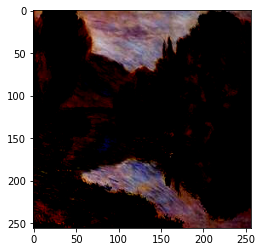

In [72]:
sample = next(iter(monet_ds))
plt.imshow(sample[0])
plt.show()

In [73]:
sample.shape

TensorShape([1, 256, 256, 3])

(28,28) for tutorial DCGAN checking 

In [74]:
IMG_SIZE = 28 
resize = keras.layers.Resizing(IMG_SIZE,IMG_SIZE)
tutorial_ds = monet_ds.map(lambda x:resize(x))

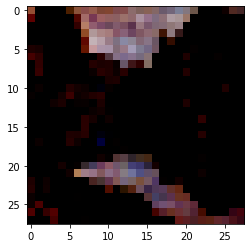

In [76]:
sample = next(iter(tutorial_ds))
plt.imshow(sample[0,:,:,:])
plt.show()

## Implementing DCGAN models 

In [78]:
noise_shape = 100 
def generator_model():
  model = keras.Sequential()
  
  model.add(layers.Dense(8*8*512,use_bias=False,input_shape =(noise_shape,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((8,8,512)))
  
  assert model.output_shape ==(None,8,8,512)
  
  model.add(layers.Conv2DTranspose(
      filters=256,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,16,16,256)

  model.add(layers.Conv2DTranspose(
      filters=128,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,32,32,128)

  model.add(layers.Conv2DTranspose(
      filters=64,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False,activation='tanh'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,64,64,64)

  model.add(layers.Conv2DTranspose(
      filters=32,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False,activation='tanh'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,128,128,32)

  model.add(layers.Conv2DTranspose(
      filters=3,kernel_size=(5,5),
      strides =(2,2),padding='same',
      use_bias=False,activation='tanh'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape ==(None,256,256,3)
  return model 

In [ ]:
def tutorial_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))
  